# **Deepfake for the Good - ImplicitDeepfake**

This is the official notebook of the paper *Deepfake for the Good: Generating Avatars through Face-Swapping with
Implicit Deepfake Generation*, avaliable on [arxiv](https://arxiv.org/abs/2402.06390). Follow the steps to reproduce the results of our research!

Just before we start, we must once again express our gratitude to the authors of the following works:


*   [GHOST 2D deepfake](https://github.com/ai-forever/ghost)
*   [Gaussian splatting volume rendering technique](https://github.com/graphdeco-inria/gaussian-splatting)


Even the content of this notebook is based on the aforementioned repos, to which we hereby give all the credit they deserve.

# **Method outline**

The general framework for our ImplicitDeepfake consists of two parts. First, we take training images of the 3D face and target image for the deepfake procedure. Then, we apply the deepfake model separately for all modified images. Next, we train neural rendering (Gaussian Splatting) on modified images to obtain a model dedicated to producing novel views.


A scheme of our pipeline is given below.

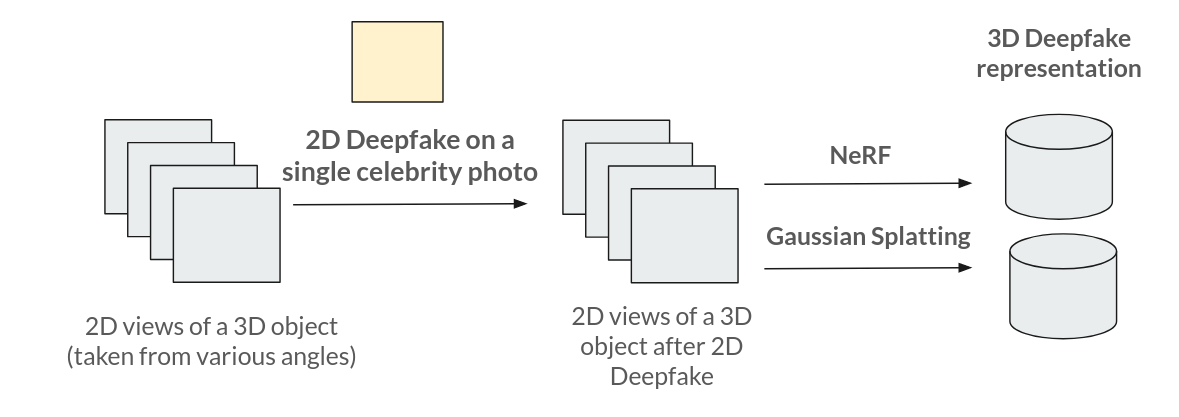

The plan to reproduce the depicted way of work is following:

1. Install the required packages
2. Prepare the dataset
3. Pass the photo dataset throught the 2D deepfake (the arrow on the left from the picture)
4. Create 3D representation of the celebrity from the photos (as NeRF is slower than Gaussian splatting - the bottom right arrow from the picture)
5. Evaluate the result

In short - let's go!

# **Required packages**

We start with creating our python working environment. Unfortunately, the only constant in the world of dependencies is a constant change (that literary a day after releasing this notebook effectively prevented it from working at all), therefore pay attention to **run the cell below, then *restart* your session (what is substantially different than *deleting* your session). Afterwards, run all the remaining cells expect the cell below (the one with package installation).**

In [ ]:
# @title Install required libraries
# -q argument is for silent installation, feel free to remove it for more verbose output

!pip install --force-reinstall numpy==1.23.5 -q
!pip install mxnet==1.6.0 -q
!pip install onnxruntime-gpu==1.12 -q
!pip install insightface==0.2.1 -q
!pip install kornia==0.5.4 -q
!pip install dill==0.3.8 -q

# the two commands below assure that you will use the most recent version of the GHOST file

!rm -f /usr/local/lib/python3.10/dist-packages/insightface/model_zoo/model_zoo.py #change the path to python in case you use a different version
!wget -qP /usr/local/lib/python3.10/dist-packages/insightface/model_zoo/ https://github.com/AlexanderGroshev/insightface/releases/download/model_zoo/model_zoo.py #change the path to python in case you use a different version

# **Dataset**

We will use Google Drive to store the dataset that we will use for the final result.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Click this [link](https://drive.google.com/drive/folders/1ZSUoqH1sv3ln-BuWznnDqSx0-Erg5TZU?usp=sharing) to access the base dataset.
It's read-only so you need to create your own copy. In case you have doubts how to achieve this goal, here is a small piece of advice from our side.

1. Go to [the dataset link](https://drive.google.com/drive/folders/1ZSUoqH1sv3ln-BuWznnDqSx0-Erg5TZU?usp=sharing)
2. Click **Shared with me** from your Google drive's account menu.
3. Find folder named **ImplicitDeepfake**
4. Click on it and **press Shift+Z** - you should see a modal with selecting location for shortcut to make the folder accessible from your Google drive's home directory. In order to do that,
5. choose **My Drive**

The folder consists of three directories that are used - as their names indicate - for training, validating and testing steps. To each of them there is an associated *transforms.json* file with entry depicting every photo's camera position, from which it was taken. We captured the photos of [this 3D model]( https://sketchfab.com/3d-models/tina-head-530fab5eb2aa44f699052624794aeaa9) and generated the .json files using blender software.


The next steps will create a 3D model of Ms. Céline Dion using these photos!

To safely edit the working directory, copy the contents of the folder we share with you. *original_dir* should point to the shared folder, while *base_dir* to the brand new location of your working directory.



In [2]:
original_dir = '/content/drive/MyDrive/ImplicitDeepfake/' # @param {type:"string"}
base_dir = '/content/drive/MyDrive/MyImplicitDeepfake/' # @param {type:"string"}
!mkdir -p "$base_dir"
!cp -R "$original_dir"* "$base_dir"

##**2D deepfake**

In this chapter we will convert all the images to their deepfake counterparts, using Ms. Dion Celeb-A photo as a source for the deepfake process. First we have to get the needed code accompanied by the pretrained model.

In [3]:
# @title Clone github repo and download 2D deepfake model

!git clone --quiet https://github.com/sberbank-ai/sber-swap.git
%cd sber-swap

# load arcface
!wget -qP ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/backbone.pth
!wget -qP ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/iresnet.py

# load landmarks detector
!wget -qP ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/glintr100.onnx
!wget -qP ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/scrfd_10g_bnkps.onnx

# load model itself
!wget -qP ./weights https://github.com/sberbank-ai/sber-swap/releases/download/sber-swap-v2.0/G_unet_2blocks.pth

# load super res model
!wget -qP ./weights https://github.com/sberbank-ai/sber-swap/releases/download/super-res/10_net_G.pth

/content/sber-swap


As everything is already settled, let's proceed with importing the needed packages.

In [ ]:
#@title Preparation

import cv2
import torch
import time
import os

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

import warnings
warnings.filterwarnings("ignore")


Luckily, we do not have to train the model from the very beginning, as the authors provided us with the **pretrained version**. We are only left with a small task of loading them - run the cell below!

In [ ]:
#@title Initialize model

app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth', map_location=torch.device('cpu')))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=-1, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = False
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

A convenient way to process the whole dataset at once is to put the idea inside a function with a loop which we will use in just a minute.

In [7]:
# @title Main loop for 2D deepfake
import os
from typing import Dict

def create_deepfakes(dirs_dict: Dict[str, int], base_dir: str, deepfake_source_img_path: str, batch_size:int):
  for dir, max_iter in dirs_dict.items():
    dir_to_save = os.path.join(base_dir, 'deepfake', dir)

    if not os.path.exists(dir_to_save):
      os.makedirs(dir_to_save)

    for i in range(max_iter):
      target_path = os.path.join(base_dir, 'dataset', dir, f'r_{i}.png')

      source_full = cv2.imread(deepfake_source_img_path)
      crop_size = 224 # don't change this

      try:
        source = crop_face(source_full, app, crop_size)[0]
        source = [source[:, :, ::-1]]
        print("Everything is ok!")
      except TypeError:
        print("Bad source images")

      target_full = cv2.imread(target_path)
      full_frames = [target_full]
      target = get_target(full_frames, app, crop_size)
      START_TIME = time.time()

      final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                        source,
                                                                                        target,
                                                                                        netArc,
                                                                                        G,
                                                                                        app,
                                                                                        set_target = False,
                                                                                        crop_size=crop_size,
                                                                                        BS=batch_size)

      result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
      cv2.imwrite(os.path.join(dir_to_save, f'r_{i}.png'), result)

What is missing in the photos after passing them to the deepfake model is their **alpha channel**. Therefore a good idea is to retain it using the alpha channel values from the base photos. Now not only do we have the dataset pictures of the celebrity, but also we enrich them with the missing channel values.

In [8]:
# @title Add alpha channel - used 2D deepfake model loses alpha channel during image transformation
from PIL import Image

def convert_to_rgba():
  folder_pairs = [('deepfake/train', 'dataset/train'), ('deepfake/val', 'dataset/val'), ('deepfake/test', 'dataset/test')]

  for rgb_folder, alpha_folder in folder_pairs:
    rgb_path = os.path.join(base_dir, rgb_folder)
    alpha_path = os.path.join(base_dir, alpha_folder)

    for filename in os.listdir(rgb_path):
      rgb_file = os.path.join(rgb_path, filename)
      alpha_file = os.path.join(alpha_path, filename)

      # Open images and convert to RGBA
      rgb_image = Image.open(rgb_file).convert('RGBA')
      alpha_image = Image.open(alpha_file).convert('RGBA')

      # Merge channels
      r, g, b, _ = rgb_image.split()
      _, _, _, a = alpha_image.split()
      rgba_image = Image.merge("RGBA", (r, g, b, a))

      rgba_image.save(os.path.join(rgb_path, filename))

Now finally we have everything settled to create the 2D deepfakes. The consecutive photos will appear in the /deepfake subdirectory. Just make sure that the **celebrity photo** of your choice - in our example the photo of Ms. Dion - is under the path stored in *deepfake_source_img_path* variable.

In [ ]:
deepfake_source_img_path = '/content/drive/MyDrive/MyImplicitDeepfake/famous.jpg'  # @param {type:"string"}
dirs_dict = {'train': 100, 'val': 50, 'test': 10}
batch_size = 40 # @param {type:"integer"}

create_deepfakes(dirs_dict, base_dir, deepfake_source_img_path, batch_size)
convert_to_rgba()

You can find modified images in `<base_dir>/deepfake` directory.

We need to have camera positions files from `<base_dir>/dataset`> in `<base_dir>/deepfake` directory to train Gaussian Splatting.

In [10]:
!cp {base_dir}/dataset/*.json {base_dir}/deepfake

##**Gaussian Splatting**

Next step is to train Gaussian Splatting on modified images. For this purpose we use [Gaussian splatting rendering technique](https://github.com/graphdeco-inria/gaussian-splatting).

In [11]:
# @title Preparation and installation
%cd /content

!git clone --quiet --recursive https://github.com/graphdeco-inria/gaussian-splatting
!pip install -q plyfile

%cd /content/gaussian-splatting
!pip install -q https://huggingface.co/camenduru/gaussian-splatting/resolve/main/diff_gaussian_rasterization-0.0.0-cp310-cp310-linux_x86_64.whl
!pip install -q https://huggingface.co/camenduru/gaussian-splatting/resolve/main/simple_knn-0.0.0-cp310-cp310-linux_x86_64.whl

# workaround for a bug connected with incompatible versions of CUDA between repo and Colab
!pip install -qU submodules/diff-gaussian-rasterization
!pip install -qU submodules/simple-knn

/content
/content/gaussian-splatting
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


**The ultimate step** is what we were aiming for since the very start. **2D deepfake dataset** is ready, the **3D rendering model** is ready and the execution of the following cell will **train** the model to achieve person's 3D representation (*python train...*), **render** the brand new photos from poses stored in *transforms_test.json* (*python test...*) and **calculate** fidelity metrics to assess the quality of the results (*python metrics.py...*).

Everything is in your hands!

In [ ]:
# @title Training, inference and metrics
source_path = os.path.join(base_dir, 'deepfake')
model_path = os.path.join(source_path, 'gaussian_white')

train_command = f"python train.py -s {source_path} --eval --model_path {model_path} --white_background"
test_command = f"python render.py -s {source_path} --skip_train --model_path {model_path} --white_background"
metrics_command = f'python metrics.py -m {model_path}'

!{train_command}
!{test_command}
!{metrics_command}

You can find results as single images in `<base_dir>/deepfake/gaussian_white/test/ours_30000/renders` directory.
Metrics values (PNSR, SSIM, LPIPS) are in `<base_dir>/deepfake/gaussian_white/results.json`.

If you want to see results as 3D model you should follow steps described [here](https://github.com/graphdeco-inria/gaussian-splatting?tab=readme-ov-file#interactive-viewers).

**That was quite a journey!** Big thanks for making it with us. We hope that the results turned out to be plausible for you as well. Just a small reminder: **remember to use deepfake software with care and according to the law!**



Have a good day,

Authors of the ImplicitDeepfake paper